In [1]:
#from IPython.display import display, Latex
#from IPython.core.display import HTML
%reset -f
%matplotlib inline
%autosave 300
from matplotlib.pylab import *
#from time import clock
#importation des bibliothèques utiles
from scipy.sparse.linalg import spsolve
from scipy.sparse import  spdiags

Autosaving every 300 seconds


# Equation de transport
On va étudier la manière d'approcher l'équation de transport 1D. 
$$
\begin{align}
&\partial_t u(t,x)+\partial_{x}u(t,x)=f(t,x),\quad \forall x\in ]0,L[,\\
&u(0,x)=u_0(x),~\forall x\in ]0,L[,\\
&u(t,0)=1,~\forall t>0.
\end {align}
$$
## Rappel du schéma décentré amont
On rappelle que le schéma décentré amont eststable sous la CFL
$$
0<\delta t \le h,
$$
puisque la vitesse de transport est ici $1$.
On introduit la discrétisation uniforme du segment $]0,L[$ par 
$$
x_i=i h, \quad i=0\cdots N,
$$
avec $h=\frac L {N}$.
On note $u_i^n$ l'approximation de $u(n \delta t,ih)$, le schéma s'écrit, 
$$
\begin{align}
&\frac {u_i^{n+1}-u_i^n}{\delta t}+\frac {u_i^{n}-u_{i-1}^n}{h}=0,~ i>0\\
&u_0^{n+1}=1.
\end {align}
$$
On obtient une suite vectorielle $(U^n)_n$ définie par récurrence,
$$
U^{n+1}=[1,(1-\frac  {\delta t} h)U^n[1,N]+\frac  {\delta t} hU^n[0,N-1]],
$$
avec $U^0$ le vecteur initial donnée par la donnée de Cauchy de l'équation de transport.


Le codage s'écrit alors simplement comme suit.

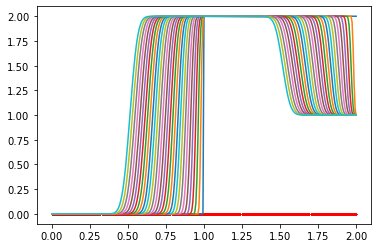

In [2]:



def decentre_amont(U,injection,CFL):
    n=size(U)
    V=U*0+injection
    if CFL>0:            
        V[1:]=(1-CFL)*U[1:]+CFL*U[:n-1]
    else: 
        V[:-1]=(1+CFL)*U[:-1]-CFL*U[1:]   
    return V
L=2
# le pas h
N=300
h=L/(N)
# construction du vecteur de discrétisation
x=linspace(0,L,N+1)
c=-0.5
#donnee initiale
U=zeros(N+1)
U[int(N/2):N+1]=2
# pas de temps
CFL=0.5
dt=CFL*h/abs(c)
CFL=sign(c)*CFL
#boucle en temps
for n in range(int(1/dt)):
    t=n*dt# utile si le critère d'arrêt porte sur le temps ou si le 
 #
    
    if (n%5==0):
        plot(x,U)
    U=decentre_amont(U,1,CFL)
    #On rajoute les points de discrétisation sur l'axe des abscisses.
    scatter(x,0*x,[0.1],'red')

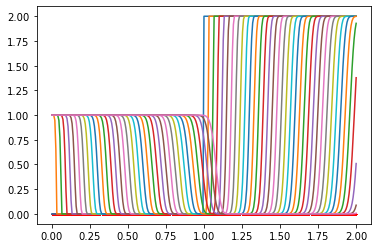

In [3]:
#donnee initiale
U=zeros(N+1)
U[int(N/2):N+1]=2

CFL=0.9
dt=CFL*h
#boucle en temps
for n in range(int(1.1/dt)):
    t=n*dt# utile si le critère d'arrêt porte sur le temps ou si le 
 #
    
    if (n%5==0):
        plot(x,U)
        
    U=decentre_amont(U,1,CFL)
    #On rajoute les points de discrétisation sur l'axe des abscisses.
    scatter(x,0*x,[0.1],'red')


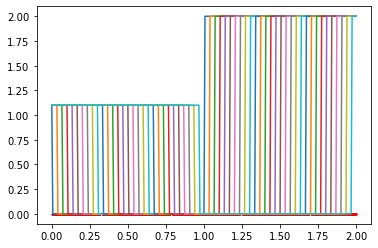

In [4]:
#donnee initiale
U=zeros(N+1)
U[int((N+1)/2):N+1]=2

CFL=1
dt=CFL*h
#boucle en temps
for n in range(int(1/dt)):
    t=n*dt# utile si le critère d'arrêt porte sur le temps ou si le 
 #
    U=decentre_amont(U,1.1,CFL)
    if (n%5==0):
        plot(x,U)
    #On rajoute les points de discrétisation sur l'axe des abscisses.
    scatter(x,0*x,[0.1],'red')

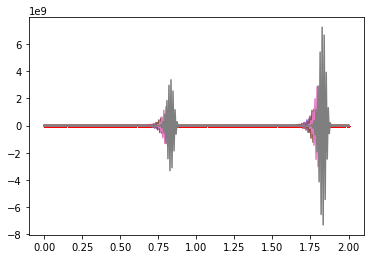

In [5]:
#donnee initiale
U=zeros(N+1)
U[int(N/2):N+1]=2

CFL=1.1
dt=CFL*h
#boucle en temps
for n in range(int(1/dt)):
    t=n*dt# utile si le critère d'arrêt porte sur le temps ou si le 
 #
    U=decentre_amont(U,1.1,CFL)
    if (n%5==0):
        plot(x,U)
    #On rajoute les points de discrétisation sur l'axe des abscisses.
    scatter(x,0*x,[0.1],'red')

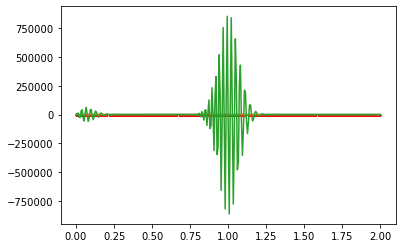

In [6]:
def richardson(U,injection,CFL):
    V=U*0+injection
    V[1:N]=U[1:N]+(-CFL)*U[2:N+1]+CFL*U[0:N-1]
    V[N]=V[N-1]
    return V

#donnee initiale
U=zeros(N+1)
U[int(N/2):N+1]=2
# pas de temps
CFL=0.3
dt=CFL*h
#boucle en temps
for n in range(int(0.3/dt)):
    t=n*dt# utile si le critère d'arrêt porte sur le temps ou si le 
 #
    U=richardson(U,1,CFL)
    if (n%50==0):
        plot(x,U)
    #On rajoute les points de discrétisation sur l'axe des abscisses.
    scatter(x,0*x,[0.1],'red')

On suppose désomrmais des CL de type périodoqie sur le domaine $[0,L]$.
$$u(t,x)=u(t,x+L), ~\forall x \in \mathbb R$$
En particulier, $u(t,L+h)=u(t,h)$, $u(t,-h)=u(t,L-h)$.
$$
\begin{align}
&\partial_t u(t,x)+\partial_{x}u(t,x)=0,\quad \forall x\in ]0,L[,\\
&u(0,x)=u_0(x),~\forall x\in ]0,L[,\\
&u(t,x+L)=u(t,x),~\forall t>0, ~\forall x\in \mathbb R.
\end {align}
$$
Pour discrétiser l'opérateur $\partial_x$ en différence finie, on choisit l'approximation centrée pour profiter de l'antisymétrie et on obtient une matrice $A$ telle que:
$$
A_{i,i+1}=\frac 1 {2h},~A_{i,i-1}=-\frac 1 {2h},
$$
La première ligne du système, en exploitant la périodicité, s'écrit
$$
0,\frac 1 {2h},0,0,....,0,-\frac 1 {2h}
$$
La deuxième ligne du système, s'écrit
$$
-\frac 1 {2h},0,\frac 1 {2h},0,0,....,0.
$$
La dernière ligne du système, s'écrit
$$
\frac 1 {2h},0,0,0,...,0,-\frac 1 {2h},0.
$$

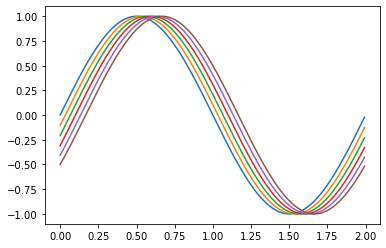

In [7]:
L=2
# le pas h
N=300
h=L/(N)

# construction du vecteur de discrétisation
x=linspace(0,L-h,N)

CFL=0.5
dt=CFL*h

D1=0.25*ones(N)
A=spdiags(D1,[1],N,N)+spdiags(-D1,[-1],N,N)+spdiags(-D1,N-1,N,N)+spdiags(D1,-N+1,N,N)


M=spdiags(ones(N),[0],N,N)+CFL*A
A=A.tocsr()
M=M.tocsr()
# condition initiale
#U=zeros(N)
#U[int(N/4):int(3/4*N)]=2
U=sin(2*pi*x/L)
for n in range(int(0.2/dt)):
    t=n*dt# utile si le critère d'arrêt porte sur le temps ou si le 
 #
    if (n%10==0):
        plot(x,U)
    SM=U-CFL*A@U
    U=spsolve(M,SM)  
    #print(U@U/h)


## Le schéma saute-mouton
ou Leap-frog.

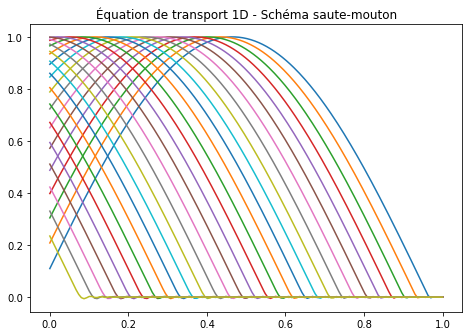

In [8]:


# Paramètres du problème
L = 1.0       # Longueur du domaine
T = 0.2       # Temps total
N = 300      # Nombre de points de grille en espace
Nt = 300      # Nombre de pas de temps
c = -.5       # Vitesse de propagation
CFL=0.95

# Discrétisation de l'espace et du temps
h = L / (N - 1)
dt=CFL*h/abs(c)
CFL=CFL*sign(c)
x = linspace(0, L, N)

u=zeros((N,3))
# Conditions initiales
u[:,0] = sin(pi * x)
#u[N//3:2*N//3]=0
# CL: on fait rentrer 0
# Schéma saute-mouton (leap-frog)

# premier pas calculer par decentré amont
u[:,1]=decentre_amont(u[:,0],0,CFL)
fig1=figure(0)
ax=fig1.add_axes([0., 0, L, 1])
for n in range(1, Nt):
    #decentré amont en sortie
    u[:,2]=decentre_amont(u[:,1],0,CFL)
    #leap-frog sauf derniere maille
    u[1:-1, 2] = u[1:-1, 0] - CFL * (u[2:, 1] - u[:-2, 1])
    u[:,:2]=u[:,1:]

    if (n%10==0):
        
        ax.plot(x,u[:,2])
      
        title('Équation de transport 1D - Schéma saute-mouton')


